In [204]:
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from downstream import downstream_factory

In [205]:
# experiment = 'no-augmentation-5-sec'
# experiment = 'no-augmentation-5-sec'
experiment = 'no-augmentation-kde-bf'
# experiment = 'augmentation-gaussian-noise-kde-bf'
# experiment = 'augmentation-flip-kde-bf'
# experiment = 'augmentation-rvae-generate'
# experiment = 'augmentation-time-shift-kde-bf'
base_dir = '../runs/' + experiment
train_recon = glob.glob(base_dir + '/**/train-reconstruction-errors.csv')
kde_perf = glob.glob(
    base_dir + '/**/downstream-task/kde/*-reconstruction-error-ctu-1-2-9*.csv')
best_run = None
max_f1 = 0
best_kde_test = None
f1s = np.array([0, 0])
precs = np.array([0, 0])
recs = np.array([0, 0])
for run in kde_perf:
    bf_data = pd.read_csv(run.replace('/kde/', '/best-fit-pdf/'), index_col=0)
    kde_data = pd.read_csv(run, index_col=0)
    f1_kde = f1_score(kde_data['label'].values, kde_data['prediction'].values)
    precision_kde = precision_score(kde_data['label'].values, kde_data['prediction'].values)
    recall_kde = recall_score(kde_data['label'].values, kde_data['prediction'].values)

    f1_bf = f1_score(bf_data['label'].values, bf_data['prediction'].values)
    precision_bf = precision_score(bf_data['label'].values, bf_data['prediction'].values)
    recall_bf = recall_score(bf_data['label'].values, bf_data['prediction'].values)

    f1s = f1s + [f1_kde, f1_bf]
    precs = precs + [precision_kde, precision_bf]
    recs = recs + [recall_kde, recall_bf]

    if f1_kde > max_f1:
        max_f1 = f1_kde
        best_run = run
        best_kde_test = kde_data

f1s = f1s / len(kde_perf)
precs = precs / len(kde_perf)
recs = recs / len(kde_perf)
# perf = pd.DataFrame(columns=['f1','precision', 'recall'],data=[f1s.T, precs.T, recs.T])
print(f1s)
print(precs)
print(recs)
print(best_run)


[0.93452221 0.91958411]
[0.88446589 0.85416963]
[0.99179894 0.99642857]
../runs/no-augmentation-kde-bf/no-augmentation-kde-bf-2022-02-04-15-52-01/downstream-task/kde/no-augmentation-kde-bf-reconstruction-error-ctu-1-2-9.csv


In [206]:
best_run_dir = '/'.join(best_run.split('/')[0:-3])
train_data = pd.read_csv(best_run_dir + '/train-reconstruction-errors.csv')
X = train_data['recon-err']
y = train_data['label']
kde = downstream_factory.get_downstream_task('kde').fit(X.values, y.values)
best_fit = downstream_factory.get_downstream_task('best-fit-pdf').fit(X.values, y.values)

/home/robin/Documents/lbnl/crd/anomaly-detection/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/robin/Documents/lbnl/crd/anomaly-detection/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/robin/Documents/lbnl/crd/anomaly-detection/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/robin/Documents/lbnl/crd/anomaly-detection/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:805: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/robin/Documents/lbnl/crd/anomaly-detection/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2804: RuntimeWarning: The shape parame

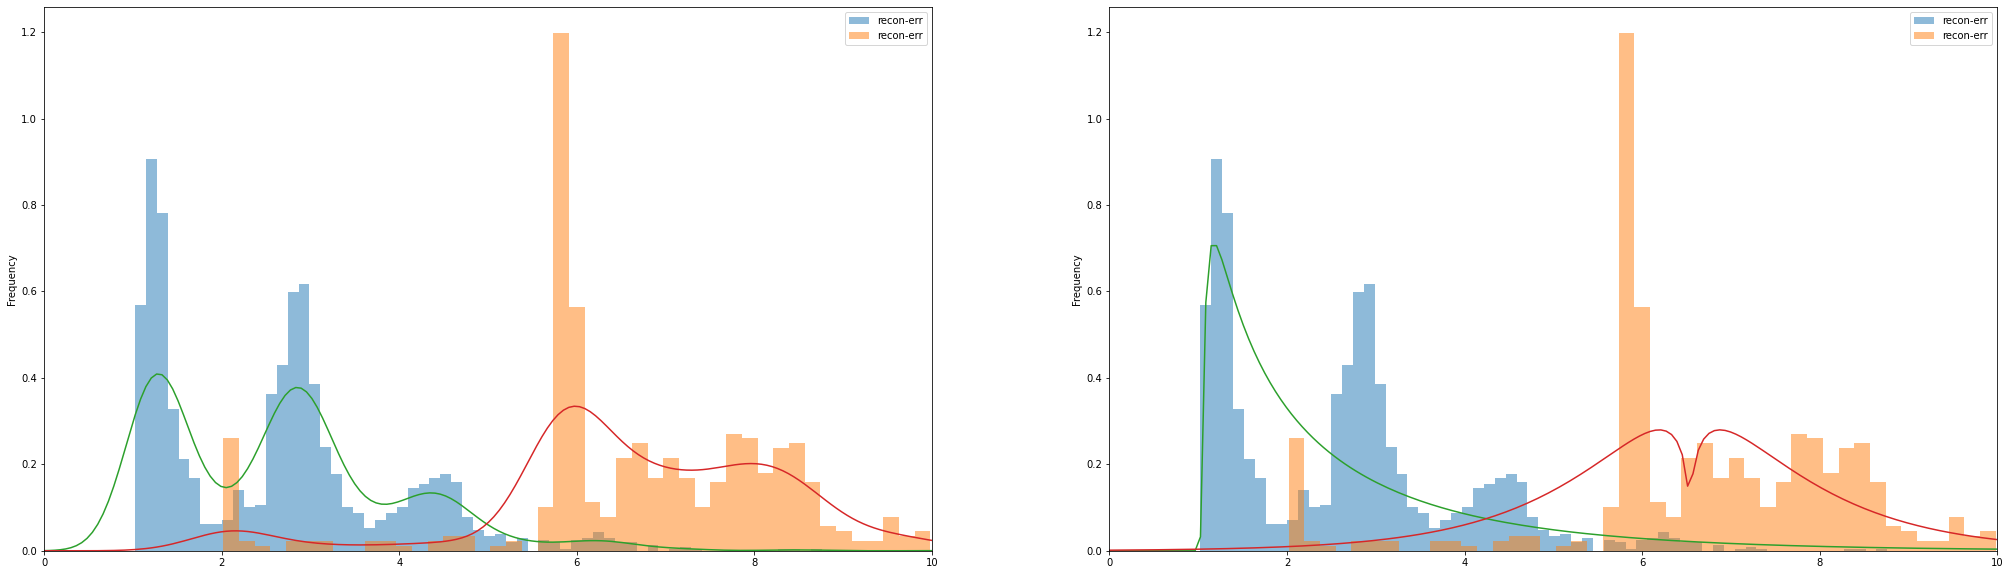

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
grouped_by_label = train_data.groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax[0], density=True, alpha=0.5)
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax[1], density=True, alpha=0.5)
xx = np.linspace(0, 12, 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
y_norm_bf = best_fit.predict_norm(xx)
y_mal_bf = best_fit.predict_mal(xx)
ax[0].set_xlim([0,10])
ax[1].set_xlim([0,10])
ax[0].plot(xx, y_norm)
ax[0].plot(xx, y_mal)

ax[1].plot(xx, y_norm_bf)
ax[1].plot(xx, y_mal_bf)
plt.savefig('./'+ experiment+ '-kde-vs-bf-training.png')
plt.show()

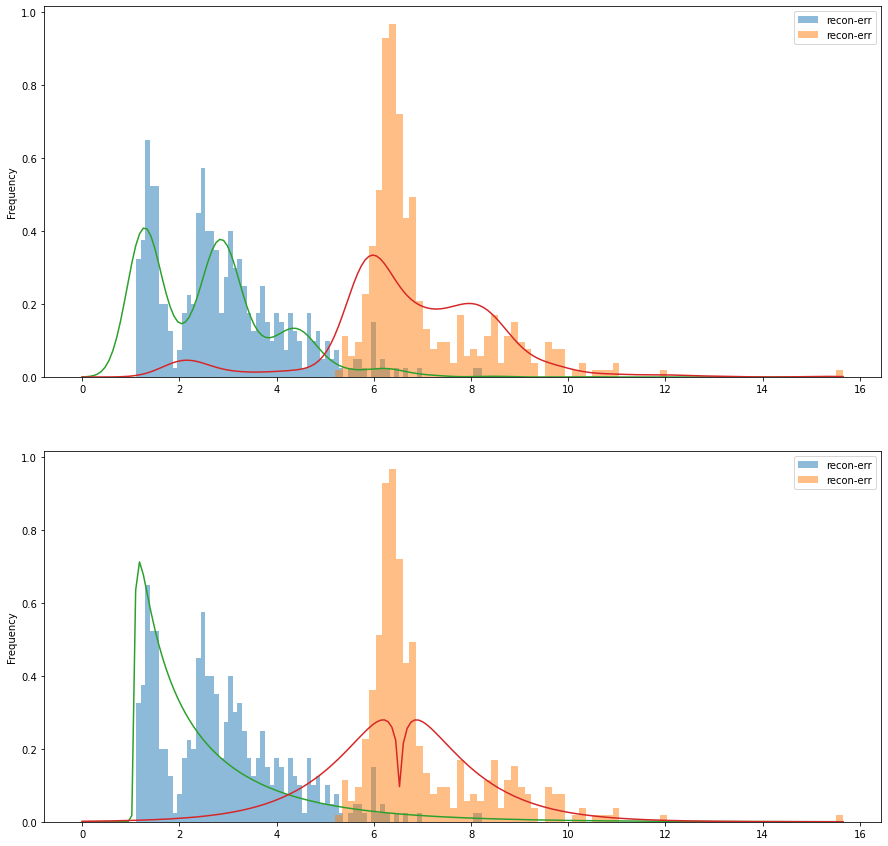

In [208]:
_, ax = plt.subplots(2, 1, figsize=(15, 15))
grouped_by_label = best_kde_test.groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax[0], density=True, alpha=0.5)
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax[1], density=True, alpha=0.5)
xx = np.linspace(0, max(best_kde_test['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
y_norm_bf = best_fit.predict_norm(xx)
y_mal_bf = best_fit.predict_mal(xx)
ax[0].plot(xx, y_norm)
ax[0].plot(xx, y_mal)
ax[1].plot(xx, y_norm_bf)
ax[1].plot(xx, y_mal_bf)
plt.savefig('./'+ experiment+ '-kde-vs-bf-test.png')
plt.show()

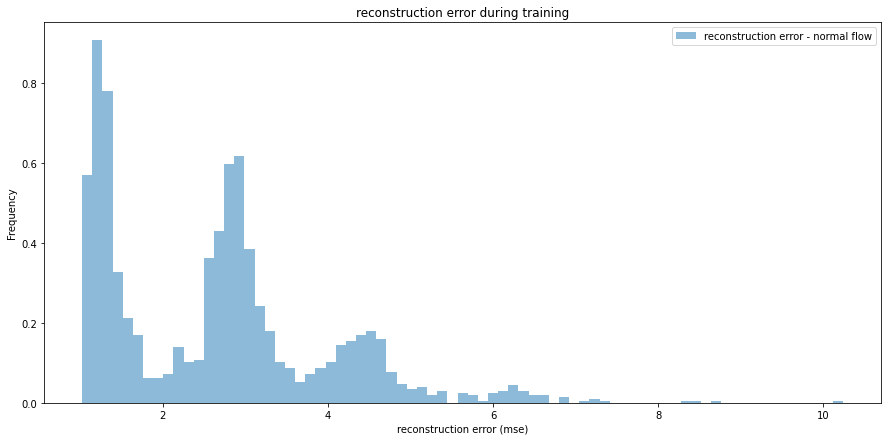

In [209]:
fig, ax = plt.subplots(figsize=(15, 7))
grouped_by_label = train_data[train_data['label'] == 0].groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5,
                      label='reconstruction error - normal flow')
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
# ax[0].plot(xx, y_norm)
# ax[0].plot(xx, y_mal)
# ax[1].plot(xx, y_norm_bf)
# ax[1].plot(xx, y_mal_bf)
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
# plt.savefig('./train_error.png')
plt.show()

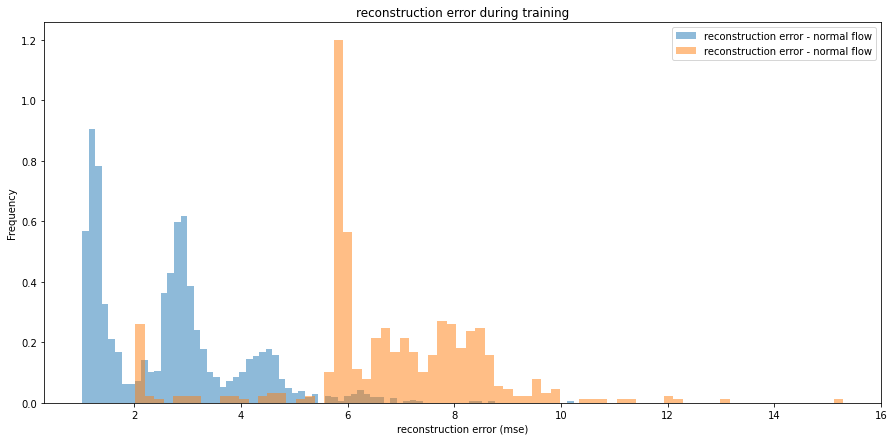

In [210]:
fig, ax = plt.subplots(figsize=(15, 7))
grouped_by_label = train_data.groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5,
                      label='reconstruction error - normal flow')
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
# ax[0].plot(xx, y_norm)
# ax[0].plot(xx, y_mal)
# ax[1].plot(xx, y_norm_bf)
# ax[1].plot(xx, y_mal_bf)
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
plt.savefig('./train_error-'+experiment+'.png')
plt.show()

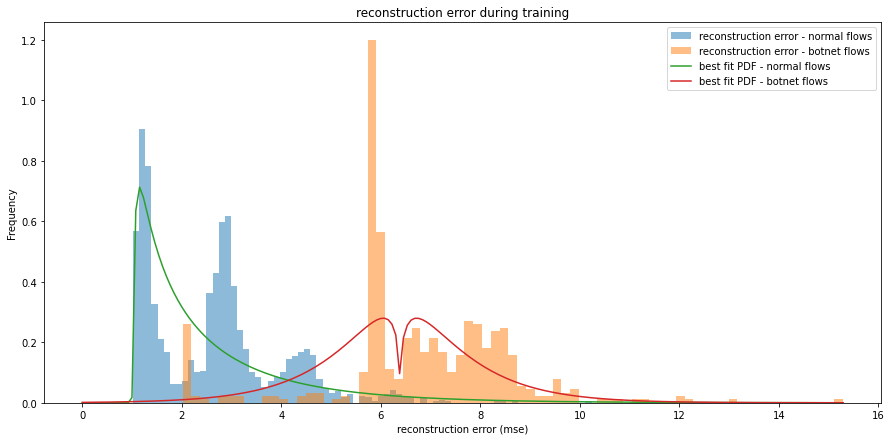

In [211]:
fig, ax = plt.subplots(figsize=(15, 7))
grouped_by_label = train_data.groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5)
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
# ax[0].plot(xx, y_norm)
# ax[0].plot(xx, y_mal)
plt.plot(xx, y_norm_bf)
plt.plot(xx, y_mal_bf)
plt.legend(
    ['reconstruction error - normal flows', 'reconstruction error - botnet flows', 'best fit PDF - normal flows',
     'best fit PDF - botnet flows'])
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
# plt.savefig('./train-bf.png')
plt.show()

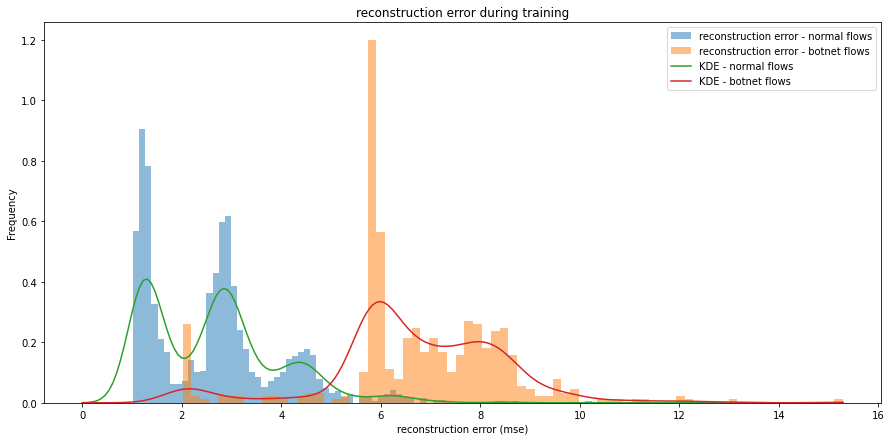

In [212]:
fig, ax = plt.subplots(figsize=(15, 7))
grouped_by_label = train_data.groupby('label')
grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5)
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
plt.plot(xx, y_norm)
plt.plot(xx, y_mal)
# plt.plot(xx, y_norm_bf)
# plt.plot(xx, y_mal_bf)
plt.legend(
    ['reconstruction error - normal flows', 'reconstruction error - botnet flows', 'KDE - normal flows',
     'KDE - botnet flows'])
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
# plt.savefig('./train-kde.png')
plt.show()

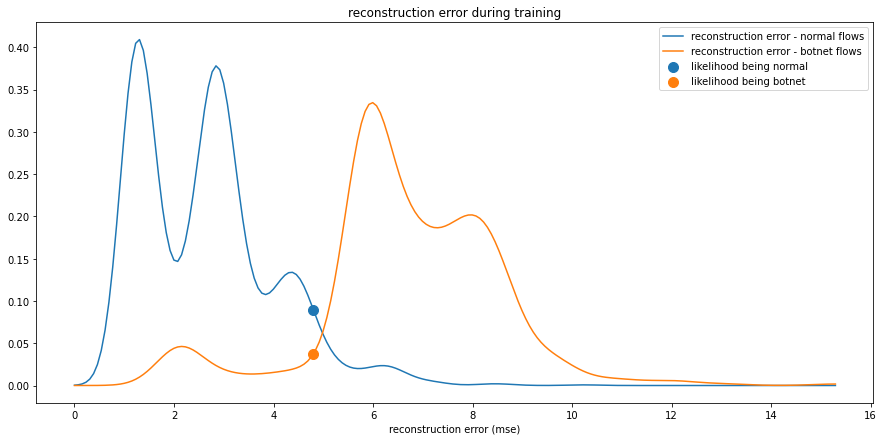

In [213]:
fig, ax = plt.subplots(figsize=(15, 7))
# grouped_by_label = train_data.groupby('label')
# grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5)
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
y_test_norm = kde.norm_pdf.evaluate(4.8)
y_test_mal = kde.mal_pdf.evaluate(4.8)
plt.plot(xx, y_norm)
plt.plot(xx, y_mal)
plt.scatter(4.8, y_test_norm, s=100)
plt.scatter(4.8, y_test_mal, s=100)
# plt.plot(xx, y_norm_bf)
# plt.plot(xx, y_mal_bf)
plt.legend(
    ['reconstruction error - normal flows', 'reconstruction error - botnet flows', 'likelihood being normal',
     'likelihood being botnet'])
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
# plt.savefig('./test-eval-kde.png')
plt.show()

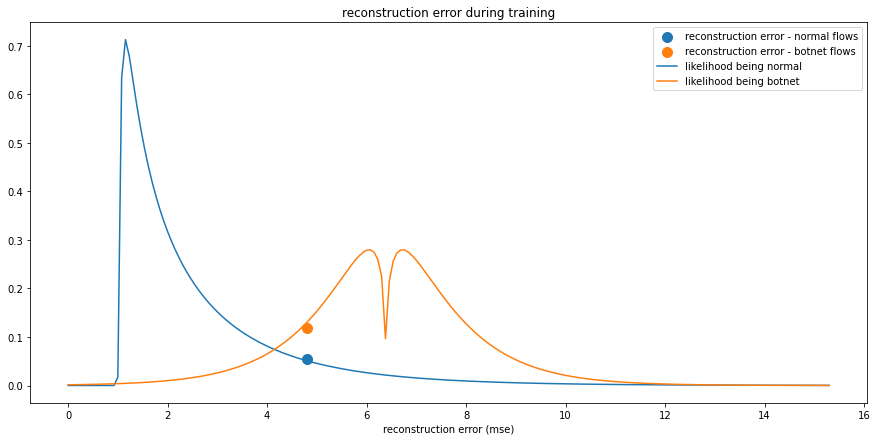

In [214]:
fig, ax = plt.subplots(figsize=(15, 7))
# grouped_by_label = train_data.groupby('label')
# grouped_by_label.plot(kind='hist', y='recon-err', bins=75, ax=ax, density=True, alpha=0.5)
xx = np.linspace(0, max(train_data['recon-err']), 200)
y_norm = kde.norm_pdf.evaluate(xx)
y_mal = kde.mal_pdf.evaluate(xx)
y_test_norm = best_fit.predict_norm(4.8)
y_test_mal = best_fit.predict_mal(4.8)
# plt.plot(xx, y_norm)
# plt.plot(xx, y_mal)
plt.scatter(4.8, y_test_norm, s=100)
plt.scatter(4.8, y_test_mal, s=100)
plt.plot(xx, y_norm_bf)
plt.plot(xx, y_mal_bf)
plt.legend(
    ['reconstruction error - normal flows', 'reconstruction error - botnet flows', 'likelihood being normal',
     'likelihood being botnet'])
plt.title('reconstruction error during training')
plt.xlabel('reconstruction error (mse)')
# plt.savefig('./test-eval-bf.png')
plt.show()